# Visualización

In [20]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Generate an extremely unbalanced dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=16, n_redundant=0, n_clusters_per_class=1, weights=[0.99, 0.01], random_state=42)

# Add some noise to the informative features
X[:, :16] += np.random.normal(loc=0, scale=1, size=X[:, :16].shape)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Compute class weights to correct the unbalancedness
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train)

# Train a random forest model without class weighting
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Random Forest Model (without class weighting)")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Train a random forest model with class weighting
rf_model_cw = RandomForestClassifier(n_estimators=100, class_weight={0: class_weights[0], 1: class_weights[1]}, random_state=42)
rf_model_cw.fit(X_train, y_train)
y_pred_cw = rf_model_cw.predict(X_test)

print("Random Forest Model (with class weighting)")
print("Accuracy Score:", accuracy_score(y_test, y_pred_cw))
print("F1 Score:", f1_score(y_test, y_pred_cw))


Random Forest Model (without class weighting)
Accuracy Score: 0.9845
F1 Score: 0.1142857142857143
Random Forest Model (with class weighting)
Accuracy Score: 0.9855
F1 Score: 0.21621621621621626


In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
data = pd.read_csv(url, header=None)
data = data.loc[0:50000,]

# Preprocess the dataset
X, y = data.iloc[:, :-1], data.iloc[:, -1]
y = y - 1  # Adjust labels to be zero-indexed

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost without parallelization (n_jobs=1)
dtrain = xgb.DMatrix(X_train, label=y_train)

param = {
    'max_depth': 8,
    'eta': 0.3,
    'objective': 'multi:softprob',
    'num_class': 7,
    'n_jobs': 1
}
num_round = 100

start_time = time.time()
bst = xgb.train(param, dtrain, num_round)
end_time = time.time()

print("Training time without parallelization: {:.2f} seconds".format(end_time - start_time))

# XGBoost with parallelization (n_jobs=-1)
param['n_jobs'] = -1

start_time = time.time()
bst_parallel = xgb.train(param, dtrain, num_round)
end_time = time.time()

print("Training time with parallelization: {:.2f} seconds".format(end_time - start_time))


Training time without parallelization: 76.35 seconds
Training time with parallelization: 21.42 seconds


Training with learning rate: 0.05
[0]	eval-logloss:0.67672
[10]	eval-logloss:0.57445
[20]	eval-logloss:0.52419
[30]	eval-logloss:0.50072
[40]	eval-logloss:0.48965
[50]	eval-logloss:0.48402
[60]	eval-logloss:0.48294
[69]	eval-logloss:0.48687
Training with learning rate: 0.1
[0]	eval-logloss:0.66118
[10]	eval-logloss:0.52066
[20]	eval-logloss:0.48747
[30]	eval-logloss:0.48011
[40]	eval-logloss:0.48598
[42]	eval-logloss:0.48465
Training with learning rate: 0.3
[0]	eval-logloss:0.60783
[10]	eval-logloss:0.46998
[20]	eval-logloss:0.48393
[25]	eval-logloss:0.51341
Training with learning rate: 0.5
[0]	eval-logloss:0.56792
[10]	eval-logloss:0.50980
[15]	eval-logloss:0.54828
Training with learning rate: 0.7
[0]	eval-logloss:0.54017
[10]	eval-logloss:0.53918
[14]	eval-logloss:0.58211


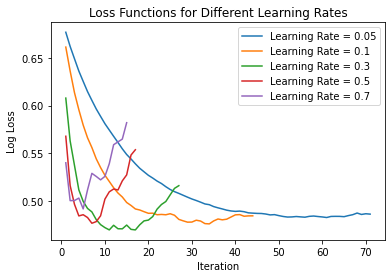

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_csv(url, names=names)
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
param = {
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
num_round = 100

# Train XGBoost with different learning rates
learning_rates = [0.05, 0.1, 0.3, 0.5, 0.7]
loss_history = {}

for lr in learning_rates:
    param['eta'] = lr
    print(f"Training with learning rate: {lr}")
    
    evals_result = {}  # Store evaluation results
    bst = xgb.train(param, dtrain, num_round, early_stopping_rounds=10, evals=[(dtest, 'eval')], evals_result=evals_result, verbose_eval=10)
    
    loss_history[lr] = evals_result['eval']['logloss']

# Plot the loss functions for each learning rate
for lr, losses in loss_history.items():
    plt.plot(range(1, len(losses) + 1), losses, label=f"Learning Rate = {lr}")

plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.legend()
plt.title("Loss Functions for Different Learning Rates")
plt.show()


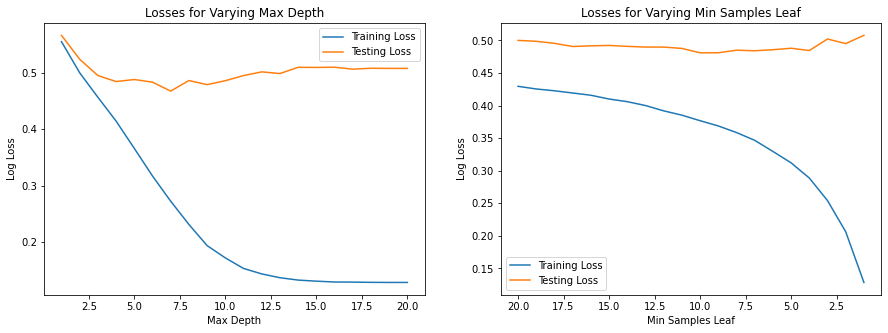

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_csv(url, names=names)
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vary max_depth hyperparameter
max_depths = list(range(1, 21))
train_losses_depth = []
test_losses_depth = []

for max_depth in max_depths:
    rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)
    
    train_proba = rf.predict_proba(X_train)
    test_proba = rf.predict_proba(X_test)
    
    train_loss = log_loss(y_train, train_proba)
    test_loss = log_loss(y_test, test_proba)
    
    train_losses_depth.append(train_loss)
    test_losses_depth.append(test_loss)

# Vary min_samples_leaf hyperparameter
min_samples_leaves = list(range(1, 21))
train_losses_leaf = []
test_losses_leaf = []

for min_samples_leaf in min_samples_leaves:
    rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=min_samples_leaf, random_state=42)
    rf.fit(X_train, y_train)
    
    train_proba = rf.predict_proba(X_train)
    test_proba = rf.predict_proba(X_test)
    
    train_loss = log_loss(y_train, train_proba)
    test_loss = log_loss(y_test, test_proba)
    
    train_losses_leaf.append(train_loss)
    test_losses_leaf.append(test_loss)

# Plot the training and testing losses for max_depth
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(max_depths, train_losses_depth, label="Training Loss")
ax1.plot(max_depths, test_losses_depth, label="Testing Loss")
ax1.set_xlabel("Max Depth")
ax1.set_ylabel("Log Loss")
ax1.legend()
ax1.set_title("Losses for Varying Max Depth")

# Plot the training and testing losses for min_samples_leaf
ax2.plot(min_samples_leaves, train_losses_leaf, label="Training Loss")
ax2.plot(min_samples_leaves, test_losses_leaf, label="Testing Loss")
ax2.set_xlabel("Min Samples Leaf")
ax2.set_ylabel("Log Loss")
ax2.legend()
ax2.set_title("Losses for Varying Min Samples Leaf")
ax2.invert_xaxis()

plt.show()


In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time

# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_csv(url, names=names)
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
param = {
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
num_round = 5000

# Train XGBoost with different learning rates
learning_rates = [0.001, 0.1]

for lr in learning_rates:
    param['eta'] = lr
    print(f"\nTraining with learning rate: {lr}")
    
    start_time = time.time()
    evals_result = {}  # Store evaluation results
    bst = xgb.train(param, dtrain, num_round, early_stopping_rounds=10, evals=[(dtest, 'eval')], evals_result=evals_result, verbose_eval=100)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")



Training with learning rate: 0.001
[0]	eval-logloss:0.69281
[100]	eval-logloss:0.66239
[200]	eval-logloss:0.63723
[300]	eval-logloss:0.61599
[400]	eval-logloss:0.59795
[500]	eval-logloss:0.58252
[600]	eval-logloss:0.56920
[700]	eval-logloss:0.55686
[800]	eval-logloss:0.54569
[900]	eval-logloss:0.53663
[1000]	eval-logloss:0.52911
[1100]	eval-logloss:0.52280
[1200]	eval-logloss:0.51694
[1300]	eval-logloss:0.51161
[1400]	eval-logloss:0.50698
[1500]	eval-logloss:0.50295
[1600]	eval-logloss:0.49946
[1700]	eval-logloss:0.49636
[1800]	eval-logloss:0.49372
[1900]	eval-logloss:0.49159
[2000]	eval-logloss:0.48968
[2100]	eval-logloss:0.48766
[2200]	eval-logloss:0.48581
[2300]	eval-logloss:0.48445
[2400]	eval-logloss:0.48396
[2492]	eval-logloss:0.48381
Elapsed time: 5.74 seconds

Training with learning rate: 0.1
[0]	eval-logloss:0.66118
[43]	eval-logloss:0.48470
Elapsed time: 0.10 seconds


Feature importances:
variance: 0.5979230403900146
skewness: 0.22082576155662537
curtosis: 0.12114560604095459
entropy: 0.0601055733859539

SHAP values:
.values =
array([[-4.597408  , -3.999211  ,  1.9574289 , -0.40484172],
       [-4.761807  , -3.843902  ,  1.9665196 , -0.40484172],
       [-6.53379   ,  2.0219142 , -1.6919757 ,  0.2507479 ],
       ...,
       [ 6.673734  ,  3.6278484 , -2.527109  , -0.15022975],
       [ 6.673734  ,  3.7334447 , -2.527109  , -0.25582612],
       [ 5.618247  ,  2.4919682 , -0.62096614,  0.33629352]],
      dtype=float32)

.base_values =
array([-0.6449131, -0.6449131, -0.6449131, ..., -0.6449131, -0.6449131,
       -0.6449131], dtype=float32)

.data =
array([[  3.6216 ,   8.6661 ,  -2.8073 ,  -0.44699],
       [  4.5459 ,   8.1674 ,  -2.4586 ,  -1.4621 ],
       [  3.866  ,  -2.6383 ,   1.9242 ,   0.10645],
       ...,
       [ -3.7503 , -13.4586 ,  17.5932 ,  -2.7771 ],
       [ -3.5637 ,  -8.3827 ,  12.393  ,  -1.2823 ],
       [ -2.5419 ,  -0.65804,

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


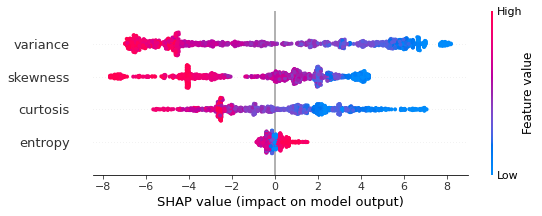

In [43]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
data = pd.read_csv(url, names=names)
X, y = data.iloc[:, :-1], data.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Compute and display feature importances
importances = model.feature_importances_
print("Feature importances:")
for name, importance in zip(X.columns, importances):
    print(f"{name}: {importance}")

# Compute and display SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

print("\nSHAP values:")
print(shap_values)

# Plot a summary plot for SHAP values
shap.summary_plot(shap_values, X)


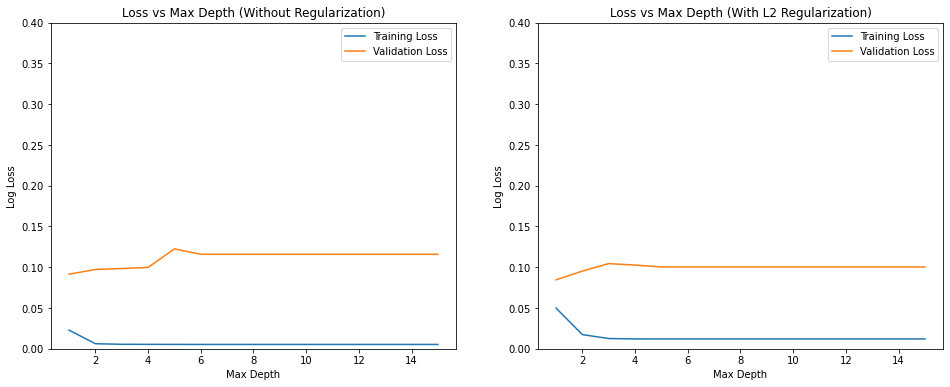

In [48]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Load the dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

train_losses_reg = []
val_losses_reg = []

max_depths = list(range(1, 16))

for max_depth in max_depths:
    # Train XGBoost without regularization
    xgb_model = xgb.XGBClassifier(max_depth=max_depth, random_state=42, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    train_loss = log_loss(y_train, xgb_model.predict_proba(X_train))
    val_loss = log_loss(y_test, xgb_model.predict_proba(X_test))
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Train XGBoost with L2 regularization (reg_lambda)
    xgb_model_reg = xgb.XGBClassifier(max_depth=max_depth, reg_lambda=10, random_state=42, n_jobs=-1)
    xgb_model_reg.fit(X_train, y_train)
    train_loss_reg = log_loss(y_train, xgb_model_reg.predict_proba(X_train))
    val_loss_reg = log_loss(y_test, xgb_model_reg.predict_proba(X_test))
    train_losses_reg.append(train_loss_reg)
    val_losses_reg.append(val_loss_reg)

# Plot the training and validation losses without regularization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(max_depths, train_losses, label="Training Loss")
ax1.plot(max_depths, val_losses, label="Validation Loss")
ax1.set_title("Loss vs Max Depth (Without Regularization)")
ax1.set_xlabel("Max Depth")
ax1.set_ylabel("Log Loss")
ax1.legend()
ax1.set_ylim(0, 0.4)  # Set the y-axis scale

# Plot the training and validation losses with L2 regularization (reg_lambda)
ax2.plot(max_depths, train_losses_reg, label="Training Loss")
ax2.plot(max_depths, val_losses_reg, label="Validation Loss")
ax2.set_title("Loss vs Max Depth (With L2 Regularization)")
ax2.set_xlabel("Max Depth")
ax2.set_ylabel("Log Loss")
ax2.legend()
ax2.set_ylim(0, 0.4)  # Set the y-axis scale

plt.show()


Kaggle Competitions: Both XGBoost and Random Forests have been very successful in various Kaggle competitions, where data scientists compete to develop the best-performing models on a wide range of datasets. For example, XGBoost has been a part of winning solutions in numerous competitions like the Higgs Boson Machine Learning Challenge, the Otto Group Product Classification Challenge, and the Allstate Claims Severity challenge. In many of these competitions, XGBoost or Random Forests outperformed other algorithms and helped participants secure top positions on the leaderboard.

Microsoft Malware Classification Challenge (BIG 2015): In this competition, participants were tasked with developing a model to classify different types of malware based on their behavior. The winning solution used an ensemble of models, with a significant portion of them being XGBoost and Random Forests. These tree-based ensemble methods outperformed other algorithms like Support Vector Machines, Neural Networks, and k-Nearest Neighbors in the classification task.

Porto Seguro's Safe Driver Prediction: This was a Kaggle competition hosted by the insurance company Porto Seguro. The goal was to predict the probability that a driver would initiate an auto insurance claim within the next year. The top solutions heavily utilized XGBoost and Random Forests, which outperformed other models like Logistic Regression and Deep Learning models. Tree-based models' ability to capture complex feature interactions and their robustness to outliers made them well-suited for this task.

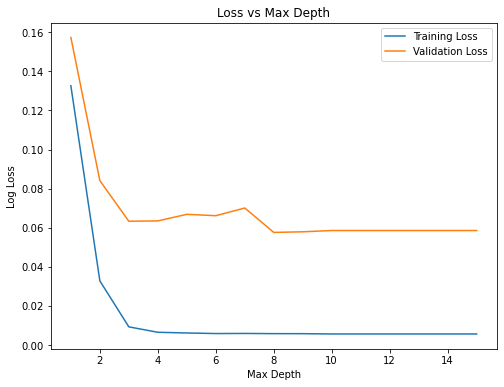

In [50]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Generate a synthetic dataset with less noise
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=2,
    n_clusters_per_class=1,
    random_state=42,
    flip_y=0.05,  # Introduce 5% noise
)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

max_depths = list(range(1, 16))

for max_depth in max_depths:
    # Train XGBoost without regularization
    xgb_model = xgb.XGBClassifier(max_depth=max_depth, random_state=42, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    train_loss = log_loss(y_train, xgb_model.predict_proba(X_train))
    val_loss = log_loss(y_test, xgb_model.predict_proba(X_test))
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot the training and validation losses
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(max_depths, train_losses, label="Training Loss")
ax.plot(max_depths, val_losses, label="Validation Loss")
ax.set_title("Loss vs Max Depth")
ax.set_xlabel("Max Depth")
ax.set_ylabel("Log Loss")
ax.legend()

plt.show()
